In [28]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
from pprint import pprint
import random
import seaborn as sns
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
import math
from tensorflow.keras.models import Model
import glob 
import xml.etree.ElementTree as ET
import torch

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [29]:
dataset_directory = "C:/Users/Kevem/OneDrive/Documents/GitHub/FaceMaskDetector/Dataset"
annotations  = dataset_directory + "/annotations"
image_directory = "C:/Users/Kevem/OneDrive/Documents/GitHub/FaceMaskDetector/Dataset/images"


In [30]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

for anno in glob.glob(annotations+ "/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file'] += [os.path.basename(anno).split('.')[0]]
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [31]:
df = pd.DataFrame(dataset)
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax
0,maksssksksss0,without_mask,512,366,79,105,109,142
1,maksssksksss0,with_mask,512,366,185,100,226,144
2,maksssksksss0,without_mask,512,366,325,90,360,141
3,maksssksksss1,with_mask,400,156,321,34,354,69
4,maksssksksss1,with_mask,400,156,224,38,261,73


In [32]:
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

df['class'] = df['name'].map(name_dict)

Counter({'with_mask': 3232, 'without_mask': 717, 'mask_weared_incorrect': 123})


<Axes: xlabel='count', ylabel='name'>

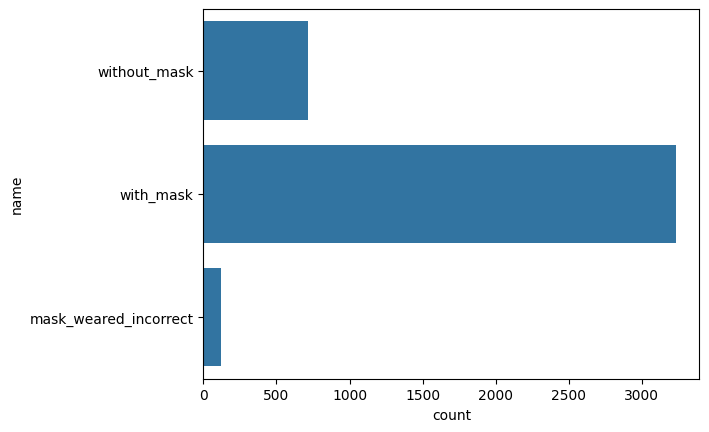

In [33]:
pprint(Counter(df['name']))
sns.countplot(df['name'])

In [34]:
np.sort(df.name.unique())

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object)

In [35]:
with_mask_count = df[df['name'] == 'with_mask'].shape[0]
mask_weared_incorrect_count = df[df['name'] == 'mask_weared_incorrect'].shape[0]
without_mask_count = df[df['name'] == 'without_mask'].shape[0]
print(f"Number of entries with 'with_mask': {with_mask_count}")
print(f"Number of entries with 'mask_weared_incorrect': {mask_weared_incorrect_count}")
print(f"Number of entries with 'without_mask': {without_mask_count}")

Number of entries with 'with_mask': 3232
Number of entries with 'mask_weared_incorrect': 123
Number of entries with 'without_mask': 717


In [36]:
filenames = [*os.listdir(image_directory)]
print(format(len(filenames)))

853


In [37]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

C:\Users\Kevem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 124, 124, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 460800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 460800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │    23,040,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,133,349 (88.25 MB)

 Trainable params: 23,133,349 (88.25 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001) ,metrics=['accuracy'])


In [39]:
# Initialize an empty list to collect images
image_list = []
Y = []
for index, row in df.iterrows():
    # Get the image file name and bounding box coordinates
    image_file = row['file']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    Y.append(row['class'])
    
    # Load the image
    img = cv2.imread(f'{image_directory}/{image_file}.png')
    
    # Check if the image was loaded successfully
    if img is not None:
        # Crop the image based on the bounding box
        cropped_img = img[ymin:ymax, xmin:xmax]
        
        # Resize the cropped image to the desired size (e.g., 124x124)
        resized_img = cv2.resize(cropped_img, (124, 124))
        
        # Normalize the image by dividing by 255.0
        normalized_img = resized_img / 255.0
        
        # Append the normalized image to the list
        image_list.append(normalized_img)
    else:
        print(f"Image {image_file} not found.")

# Convert the list to a numpy array
X = np.array(image_list) / 255.0
Y = np.array(Y)

# Check the shape of X
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (4072, 124, 124, 3)
Shape of Y: (4072,)


In [64]:
xtrain,xtest,ytrain,ytest=train_test_split(X, Y,train_size=0.8,random_state=0)
xtrain,xval,ytrain,yval=train_test_split(xtrain, ytrain,train_size=0.2,random_state=0)

In [65]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [66]:
early_stop = EarlyStopping(monitor='accuracy',patience=4,mode='max')

In [67]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [68]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to prevent OOM errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is configured!")
    except RuntimeError as e:
        print(e)

In [69]:
import torch

# Print the device that PyTorch is using
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0)}")

Using device: NVIDIA GeForce RTX 4070 Ti


In [70]:
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=16),
                    epochs=80,
                    callbacks=[early_stop],
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/80


C:\Users\Kevem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 553ms/step - accuracy: 0.6346 - loss: 0.3115 - val_accuracy: 0.6815 - val_loss: 0.2008
Epoch 2/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 557ms/step - accuracy: 0.6362 - loss: 0.2981 - val_accuracy: 0.6520 - val_loss: 0.1438
Epoch 3/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 543ms/step - accuracy: 0.6635 - loss: 0.2599 - val_accuracy: 0.6727 - val_loss: 0.1243
Epoch 4/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 530ms/step - accuracy: 0.6700 - loss: 0.2519 - val_accuracy: 0.6447 - val_loss: 0.0599
Epoch 5/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 535ms/step - accuracy: 0.6460 - loss: 0.1865 - val_accuracy: 0.6769 - val_loss: 0.0521
Epoch 6/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 541ms/step - accuracy: 0.6515 - loss: 0.2916 - val_accuracy: 0.6658 - val_loss: 0.0027
Epoch 7/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 572ms/step - accuracy: 0.6726 - loss: 0.0928 - val_accuracy: 0.6566 - val_loss: -0.0680


In [71]:
test_loss,test_accuracy = model.evaluate(xtest, ytest)
print('Test Loss for Model: ',test_loss)
print('Test Accuracy for Model: ',test_accuracy)

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.6770 - loss: -0.1234
Test Loss for Model:  -0.0929798036813736
Test Accuracy for Model:  0.6858895421028137


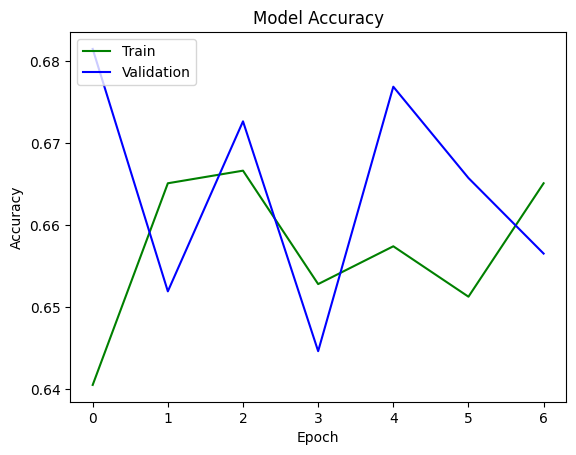

In [72]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

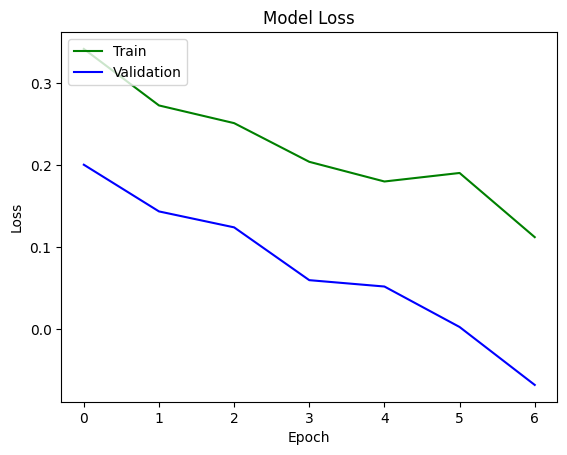

In [73]:

plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [74]:
model.save("mask_prediction.h5")

In [75]:
cvNet = cv2.dnn.readNetFromCaffe('model/architecture.txt','model/weights.caffemodel')

In [76]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [77]:
def processImage(image):
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.15, (36,255,12), 3)
        except:pass
    return image

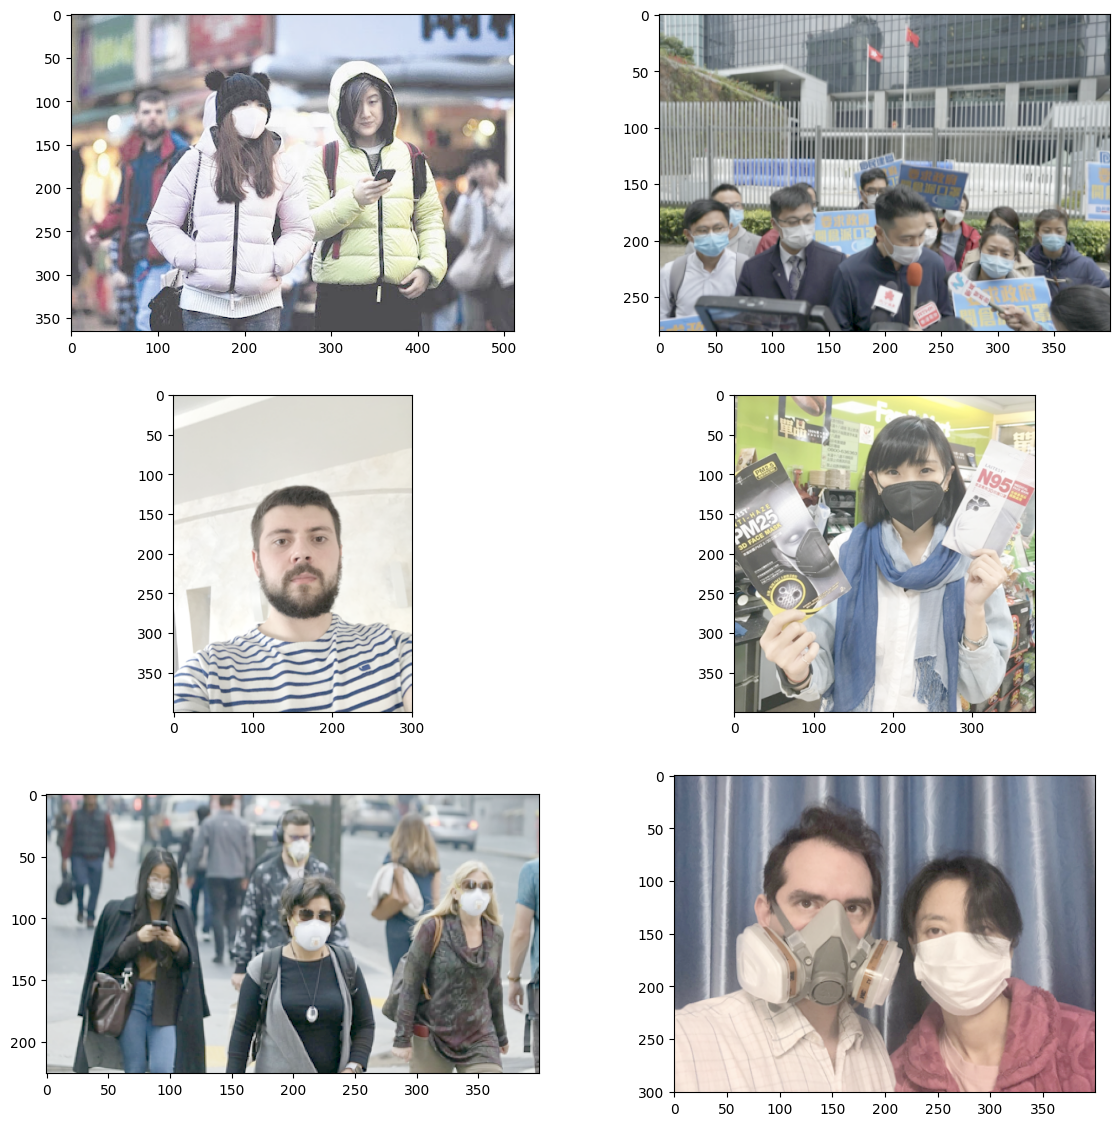

In [78]:

test_images = ['maksssksksss0.png','maksssksksss41.png', 'maksssksksss51.png','maksssksksss66.png',
               'maksssksksss53.png','maksssksksss123.png']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','2':"No Mask",'1':'Incorrect Mask'}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image = processImage(image)
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [79]:
layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]
layer_list

INTERESTED_CONV_LAYERS = ["conv2d", "conv2d_1", "conv2d_2"]

idx = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:        
        layer_output = layer[1].output
        filters, bias = layer[1].get_weights()     
        filters = (filters - filters.min()) / (filters.max() - filters.min())
    
        cols = 20
        rows = math.ceil(filters.shape[-1] / cols)
        fig = plt.figure(idx, (20, rows))

        idx += 1
        for i,f in enumerate(np.rollaxis(filters, 3)):
            ax = plt.subplot(rows, cols, i+1)
            f = np.mean(f, axis=2)
            ax.imshow(f, cmap="viridis")
            ax.set_xticks([])
            ax.set_yticks([])
            plt.suptitle(f"layer name: {layer[0]}, {filters.shape[3]} filters of shape {filters.shape[:-1]}", fontsize=20, y=1.1)
            plt.tight_layout()


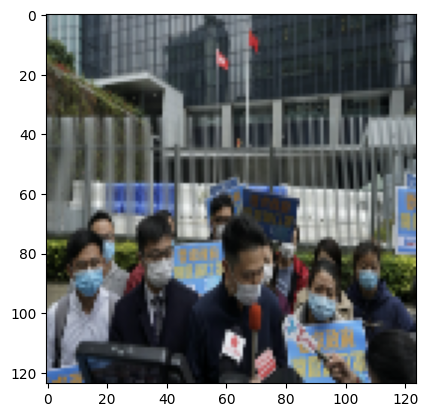

(124, 124, 3)


In [80]:

layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]

sample_img = cv2.imread(os.path.join(image_directory,'maksssksksss41.png'))

sample_img = cv2.resize(sample_img,(124,124))
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.show()
# plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
print(sample_img.shape)

sample_img = np.expand_dims(sample_img, axis=0)

i = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:    
        model_conv2d = Model(inputs=model.inputs, outputs=layer[1].output)
        featuremaps_conv2d = model_conv2d.predict(sample_img)

        cols = 20
        rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)
        fig = plt.figure(i, (20, rows))        
        i += 1
        
        for idx, feature_map in enumerate(np.rollaxis(featuremaps_conv2d, axis=3)):
            ax = plt.subplot(rows, cols ,idx+1)
            ax.imshow(feature_map[0], cmap="gray")
            ax.set_xticks([])
            ax.set_yticks([])
            plt.suptitle(f"layer name: {layer[0]}, feature map shape: {featuremaps_conv2d.shape}", fontsize=20, y=1.1)
            plt.tight_layout()